In [23]:
import torch
import torch.nn as nn
import pandas as pd
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
import numpy as np

In [24]:
device = 'cpu'

Import models

In [25]:
from models_py.one_day_lstm import LSTMPrediction as one_day_lstm
from models_py.one_day_lstm_tweaked import LSTMPrediction as one_day_lstm_tweaked
from models_py.one_week_seq2seq_multi_input import Seq2SeqPrediction as seq2seq_one_week

model1 = one_day_lstm(16, 128, 2, 1, 0.2) #365 Lookback
model2 = one_day_lstm(16, 128, 3, 1, 0.2) #30 Lookback
model3 = one_day_lstm_tweaked(6, 256, 3, 1, 0.2)
model4 = seq2seq_one_week(6, 3, 4, 256, 3, 0.2)

Import weights

In [26]:
model1.load_state_dict(torch.load('./weights/od_lstm-2l-128hs-0.2d-365lb-125e-all.pth', map_location='cpu'))
model2.load_state_dict(torch.load('./weights/one_day_lstm-125e-3l-0_2d.pth'))
model3.load_state_dict(torch.load('./weights/od_lstm-3l-256hs-0.2d-30lb-110e-ohlvdm.pth', map_location='cpu'))
model4.load_state_dict(torch.load('./weights/ow_ms2s-3l-256hs-0.2d-30lb-200e-ohlvdm.pth', map_location='cpu'))

<All keys matched successfully>

Evaluate

In [27]:
from create_train_loader import create_data_loader as data_loader

from simulations.one_day_simulation import simulation

In [28]:
def evaluate(model, test_loader, criterion, X_scaler, y_scaler):
	model.eval()
	test_loss = 0
	predictions = []
	truths = []

	with torch.no_grad():
		for X_batch, y_batch in test_loader:
			X_batch = X_batch
			y_batch = y_batch
			
			y_pred = model(X_batch)
			loss = criterion(y_pred, y_batch)

			test_loss += loss.item()

			# Add the predicted and actual values for plotting
			# Move to the CPU and convert the tensor to a numpy array
			predictions.append(y_pred.cpu().numpy())
			truths.append(y_batch.cpu().numpy())

	test_loss /= len(test_loader)

	predictions = np.concatenate(predictions, axis=0)
	truths = np.concatenate(truths, axis=0)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))

	print(f"Test Loss: {test_loss:.6f}")

	print("\nNormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	# Inverse the normalization to get the actual BTC prices
	predictions = y_scaler.inverse_transform(predictions)
	truths = y_scaler.inverse_transform(truths)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))
	print("\nUnnormalized")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	return predictions, truths


Model1 - First LSTM with all features. 365 Days lookback

Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114
Train samples: 3384
Test samples: 365
Test Loss: 0.040163

Normalized
MSE: 0.039882
RMSE: 0.199704
MAE: 0.144434
MAPE: 0.326599

Unnormalized
MSE: 111960056.000000
RMSE: 10581.118164
MAE: 7652.686523
MAPE: 0.087410


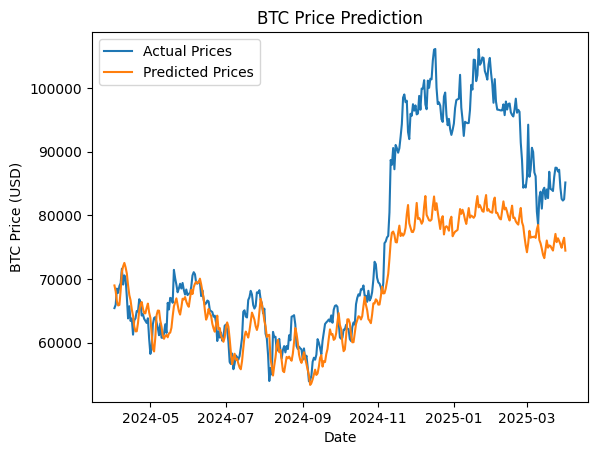

Money: 1059.4683837890625 Buy count: 5 Sell count: 5


np.float32(1059.4684)

In [29]:
feature_columns = ['open', 'high', 'low', 'volume', 'marketCap', 'meanTxFee',
				  'txCnt', 'activeAddressCnt', 'hashRate', 'difficulty', 'revenuePerHash',
				  'dayOfWeek', 'dayOfMonth', 'month', 'quarter', 'isWeekend']
target_column = 'close'

test_loader, test_dates, X_scaler, y_scaler = data_loader(feature_columns=feature_columns, target_column=target_column, batch_size=64, lookback_length=365, test_length=365)

criterion = nn.MSELoss()
predictions, actuals = evaluate(model1, test_loader, criterion, X_scaler, y_scaler)

plt.plot(test_dates, actuals, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

simulation(1000, actuals, predictions, 0.98)

Model 2 - Increase to 3 layers

Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114
Train samples: 3384
Test samples: 365
Test Loss: 0.002345

Normalized
MSE: 0.002284
RMSE: 0.047796
MAE: 0.036401
MAPE: 0.153923

Unnormalized
MSE: 6413114.000000
RMSE: 2532.412598
MAE: 1928.676514
MAPE: 0.025002


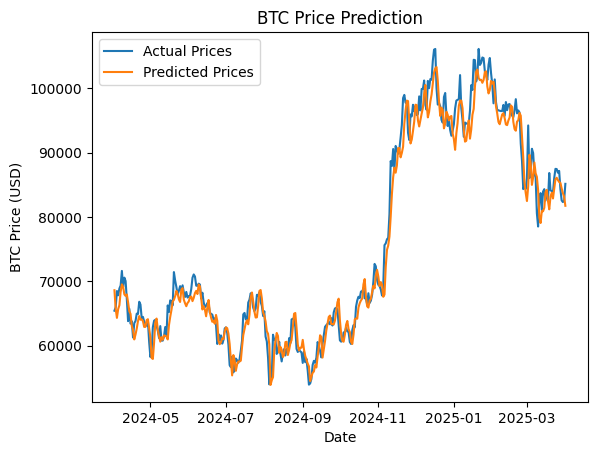

Money: 833.1787719726562 Buy count: 16 Sell count: 16


np.float32(833.1788)

In [30]:
feature_columns = ['open', 'high', 'low', 'volume', 'marketCap', 'meanTxFee',
				  'txCnt', 'activeAddressCnt', 'hashRate', 'difficulty', 'revenuePerHash',
				  'dayOfWeek', 'dayOfMonth', 'month', 'quarter', 'isWeekend']
target_column = 'close'

test_loader, test_dates, X_scaler, y_scaler = data_loader(feature_columns=feature_columns, target_column=target_column, batch_size=64, lookback_length=365, test_length=365)

criterion = nn.MSELoss()
predictions, actuals = evaluate(model2, test_loader, criterion, X_scaler, y_scaler)

plt.plot(test_dates, actuals, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

simulation(1000, actuals, predictions, 0.98)

Model 3

Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114
Train samples: 3719
Test samples: 365
Test Loss: 0.002343

Normalized
MSE: 0.002262
RMSE: 0.047561
MAE: 0.035825
MAPE: 0.158169

Unnormalized
MSE: 6350312.000000
RMSE: 2519.982422
MAE: 1898.156860
MAPE: 0.024825


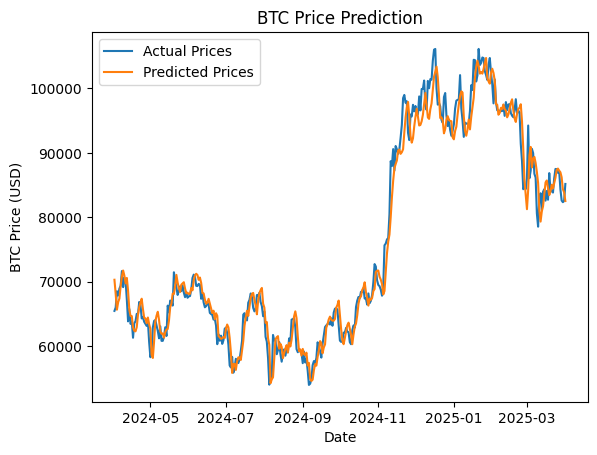

Money: 788.619873046875 Buy count: 12 Sell count: 12


np.float32(788.6199)

In [31]:
feature_columns = ['open', 'high', 'low', 'volume', 'dayOfWeek', 'month']
target_column = 'close'

test_loader, test_dates, X_scaler, y_scaler = data_loader(feature_columns=feature_columns, target_column=target_column, batch_size=64, lookback_length=30, test_length=365)

criterion = nn.MSELoss()
predictions, actuals = evaluate(model3, test_loader, criterion, X_scaler, y_scaler)

plt.plot(test_dates, actuals, label='Actual Prices')
plt.plot(test_dates, predictions, label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()

simulation(1000, actuals, predictions, 0.98)

Model 4

Using device: cpu
Data range: 2013-12-27 00:00:00 to 2025-04-01 00:00:00
Total samples: 4114
[-0.98893308 -0.9896095  -0.98968629 -0.99974924  0.33333333  1.        ]
Input shape: torch.Size([128, 30, 1])
Output shape: torch.Size([128, 7, 1])
Test Loss: 0.129316
MSE: 0.122221
RMSE: 0.349601
MAE: 0.268034
MAPE: 0.706287

Unnormalized
MSE: 343111296.000000
RMSE: 18523.263672
MAE: 14201.531250
MAPE: 0.168190


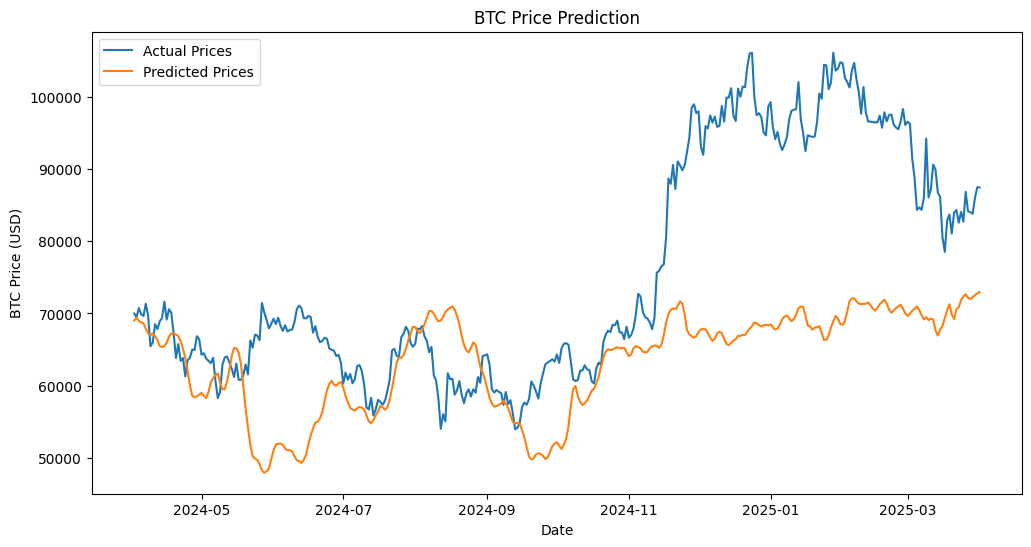

In [32]:
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
np.random.seed(0)

BATCH_SIZE = 128
LOOKBACK_LENGTH = 30
PREDICTION_LENGTH = 7
TEST_LENGTH = 365
DROPOUT = 0.2
DAY_SIZE = 3
MONTH_SIZE = 4
HIDDEN_SIZE = 256
NUM_LAYERS = 3
LEARNING_RATE = 0.001
EPOCHS = 200

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Load and sort the data
data = pd.read_csv("./data/BTC Data 2013-12-27 2025-04-01.csv")
data['date'] = pd.to_datetime(data['date'])
data = data.sort_values('date')

print(f"Data range: {data['date'].min()} to {data['date'].max()}")
print(f"Total samples: {len(data)}")

data['dayOfWeek'] = data['date'].dt.dayofweek
data['month'] = data['date'].dt.month - 1

feature_columns = ['open', 'high', 'low', 'volume', 'dayOfWeek', 'month']
target_column = 'close'

X = data[feature_columns].values
y = data[target_column].values.reshape(-1, 1)

X_scaler = MinMaxScaler(feature_range=(-1, 1))
y_scaler = MinMaxScaler(feature_range=(-1, 1))
X_normalized = X_scaler.fit_transform(X)
y_normalized = y_scaler.fit_transform(y)
print(X_normalized[0])

X_open = X_normalized[:, [0]]
X_high = X_normalized[:, [1]]
X_low = X_normalized[:, [2]]
X_volume = X_normalized[:, [3]]
X_dayOfWeek = X[:, [4]]
X_month = X[:, [5]]

class TimeSeriesDataset(Dataset):
	def __init__(self, X_open, X_high, X_low, X_volume, X_dayOfWeek, X_month, Y):
		self.X_open = torch.FloatTensor(X_open)
		self.X_high = torch.FloatTensor(X_high)
		self.X_low = torch.FloatTensor(X_low)
		self.X_volume = torch.FloatTensor(X_volume)
		self.X_dayOfWeek = torch.LongTensor(X_dayOfWeek)
		self.X_month = torch.LongTensor(X_month)
		self.Y = torch.FloatTensor(Y)

	def __len__(self):
		return len(self.X_open)

	def __getitem__(self, i):
		return (
			self.X_open[i],
			self.X_high[i],
			self.X_low[i],
			self.X_volume[i],
			self.X_dayOfWeek[i],
			self.X_month[i]
		), self.Y[i]

def create_X_sequences(X, history, prediction):
	X_seq = []
	
	for i in range(len(X) - history - prediction):
		X_seq.append(X[i:i + history])
	
	return np.array(X_seq)

def create_y_sequences(y, history, prediction):
	Y_seq = []
	
	for i in range(len(X) - history - prediction):
		Y_seq.append(y[i + history:i + history + prediction])
	
	return np.array(Y_seq)

X_open_seq = create_X_sequences(X_normalized[:, [0]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_high_seq = create_X_sequences(X_normalized[:, [1]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_low_seq = create_X_sequences(X_normalized[:, [2]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_volume_seq = create_X_sequences(X_normalized[:, [3]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_dayOfWeek_seq = create_X_sequences(X[:, [4]], LOOKBACK_LENGTH, PREDICTION_LENGTH)
X_month_seq = create_X_sequences(X[:, [5]], LOOKBACK_LENGTH, PREDICTION_LENGTH)

Y_seq = create_y_sequences(y_normalized, LOOKBACK_LENGTH, PREDICTION_LENGTH)

test_dates = data['date'].iloc[-TEST_LENGTH:]

train_X_open = X_open_seq[:-TEST_LENGTH]
train_X_high = X_high_seq[:-TEST_LENGTH]
train_X_low = X_low_seq[:-TEST_LENGTH]
train_X_volume = X_volume_seq[:-TEST_LENGTH]
train_X_dayOfWeek = X_dayOfWeek_seq[:-TEST_LENGTH]
train_X_month = X_month_seq[:-TEST_LENGTH]
train_Y = Y_seq[:-TEST_LENGTH]

test_X_open = X_open_seq[-TEST_LENGTH:]
test_X_high = X_high_seq[-TEST_LENGTH:]
test_X_low = X_low_seq[-TEST_LENGTH:]
test_X_volume = X_volume_seq[-TEST_LENGTH:]
test_X_dayOfWeek = X_dayOfWeek_seq[-TEST_LENGTH:]
test_X_month = X_month_seq[-TEST_LENGTH:]
test_Y = Y_seq[-TEST_LENGTH:]

train_dataset = TimeSeriesDataset(
	train_X_open, train_X_high, train_X_low, train_X_volume,
	train_X_dayOfWeek, train_X_month, train_Y
)
test_dataset = TimeSeriesDataset(
	test_X_open, test_X_high, test_X_low, test_X_volume,
	test_X_dayOfWeek, test_X_month, test_Y
)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

for X_batch, Y_batch in train_loader:
	print(f"Input shape: {X_batch[0].shape}")
	print(f"Output shape: {Y_batch.shape}")
	break

def evaluate(model, test_loader, criterion):
	model.eval()
	test_loss = 0
	predictions = []
	truths = []

	with torch.no_grad():
		for X_batch, y_batch in test_loader:
			X_batch = [x.to(device) for x in X_batch]
			y_batch = y_batch.to(device)
			
			y_pred = model(X_batch, PREDICTION_LENGTH)
			loss = criterion(y_pred, y_batch)

			test_loss += loss.item()

			# Add the predicted and actual values for plotting
			# Move to the CPU and convert the tensor to a numpy array
			predictions.append(y_pred.cpu().numpy())
			truths.append(y_batch.cpu().numpy())

	test_loss /= len(test_loader)

	predictions = np.concatenate(predictions, axis=0)
	truths = np.concatenate(truths, axis=0)

	mse = np.mean((predictions - truths) ** 2)
	rmse = np.sqrt(mse)
	mae = np.mean(np.abs(predictions - truths))
	mape = np.mean(np.abs((truths - predictions) / truths))

	print(f"Test Loss: {test_loss:.6f}")
	print(f"MSE: {mse:.6f}")
	print(f"RMSE: {rmse:.6f}")
	print(f"MAE: {mae:.6f}")
	print(f"MAPE: {mape:.6f}")

	predictions = predictions[:, :, 0:1]
	batch_size, seq_len = predictions.shape[:2]

	predictions = y_scaler.inverse_transform(predictions.reshape(-1, 1)).reshape(batch_size, seq_len, 1)
	truths = y_scaler.inverse_transform(truths.reshape(-1, 1)).reshape(truths.shape)

	mse2 = np.mean((predictions - truths) ** 2)
	rmse2 = np.sqrt(mse2)
	mae2 = np.mean(np.abs(predictions - truths))
	mape2 = np.mean(np.abs((truths - predictions) / truths))
	print("\nUnnormalized")
	print(f"MSE: {mse2:.6f}")
	print(f"RMSE: {rmse2:.6f}")
	print(f"MAE: {mae2:.6f}")
	print(f"MAPE: {mape2:.6f}")

	return predictions, truths

predictions, actuals = evaluate(model4, test_loader, criterion)

plt.figure(figsize=(12, 6))
plt.plot(test_dates, actuals[:, 0, 0], label='Actual Prices')
plt.plot(test_dates, predictions[:, 0, 0], label='Predicted Prices')
plt.xlabel('Date')
plt.ylabel('BTC Price (USD)')
plt.title('BTC Price Prediction')
plt.legend()
plt.show()